In [1]:
import sys
sys.path += [".."]

import smbh
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sympy as spy
spy.init_printing()

In [3]:
def getPotential(density):
    global G, a_1, a_2, a_3, tau, m, x, y, z, m_int
    k = spy.symbols(r'k', real = True, positive = True)
    rho = density.subs(m, spy.sqrt(k))
    psi = -spy.integrate(rho, k)
    psi = psi.subs(k, m ** 2)
    
    Phi = - spy.pi * G * (a_2 * a_3 / a_1) * psi * 1 / spy.sqrt((tau + a_1 ** 2) * (tau + a_2 ** 2) * (tau + a_3 ** 2))
    return Phi

def gradient(Phi):
    global x, y, z, m, m_int
    phi = Phi.subs(m, m_int)
    dim = [x, y, z]
    return [phi.diff(i).subs(m_int / a_1, m).subs((m_int / a_1) ** 2, m ** 2) for i in dim]

def toSpherical(phi):
    global a_1, a_2, a_3, x, y, z, r
    subs = [(a_1, 1), (a_2, 1), (a_3, 1), (x * x + y * y + z * z, r * r)]
    return phi.subs(subs)

def changeVariables(func):
    global tau
    return func.subs(tau, omega / (1 - omega)) / (1 - omega) ** 2

def gradToLatex(grad):
    new_m = r'm(\vec{x}, \tau)'
    latex = [spy.latex(g).replace('m ', new_m).replace(r'm\right)', new_m + r'\right)') for g in grad]
    txt = r"""\nabla \Phi = 
        \left(\begin{array}{l}
        %s, \\
        %s, \\
        %s
        \end{array}\right)""" % tuple(latex)
    print(txt)

# Potentials

In [4]:
G, tau, omega = spy.symbols(r'G \tau \omega', real = True, positive = True)
r, m, x, y, z, a_1, a_2, a_3 = spy.symbols("r m x y z a_1 a_2 a_3", real = True, positive = True)

m_int = [i ** 2 / (a ** 2 + tau) for (i, a) in zip([x, y, z], [a_1, a_2, a_3])]
m_int = spy.sqrt(a_1 ** 2 * sum(m_int))

# NFW

In [5]:
rho_0, R_s = spy.symbols(r"\rho_0 R_s", real = True, positive = True)

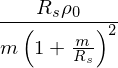

In [6]:
NFW = rho_0 / ((m / R_s) * (1 + m / R_s) ** 2)
NFW

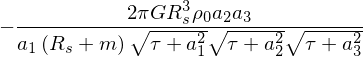

In [7]:
Phi = getPotential(NFW)
Phi

In [8]:
grad = gradient(Phi)
gradToLatex(grad)

\nabla \Phi = 
        \left(\begin{array}{l}
        \frac{2 \pi G R_{s}^{3} \rho_0 a_{2} a_{3} x}{m(\vec{x}, \tau)\left(R_{s} + a_{1} m(\vec{x}, \tau)\right)^{2} \left(\tau + a_{1}^{2}\right)^{\frac{3}{2}} \sqrt{\tau + a_{2}^{2}} \sqrt{\tau + a_{3}^{2}}}, \\
        \frac{2 \pi G R_{s}^{3} \rho_0 a_{2} a_{3} y}{m(\vec{x}, \tau)\left(R_{s} + a_{1} m(\vec{x}, \tau)\right)^{2} \sqrt{\tau + a_{1}^{2}} \left(\tau + a_{2}^{2}\right)^{\frac{3}{2}} \sqrt{\tau + a_{3}^{2}}}, \\
        \frac{2 \pi G R_{s}^{3} \rho_0 a_{2} a_{3} z}{m(\vec{x}, \tau)\left(R_{s} + a_{1} m(\vec{x}, \tau)\right)^{2} \sqrt{\tau + a_{1}^{2}} \sqrt{\tau + a_{2}^{2}} \left(\tau + a_{3}^{2}\right)^{\frac{3}{2}}}
        \end{array}\right)


# Hernquist

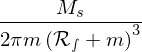

In [9]:
M_s, r_s = spy.symbols(r"M_s \mathcal{R_s}", real = True, positive = True)
Hernquist = M_s / (2 * spy.pi * m * (m + r_s) ** 3)
Hernquist

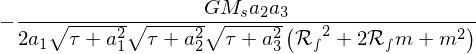

In [10]:
Phi = getPotential(Hernquist)
Phi

In [11]:
grad = gradient(Phi)
gradToLatex(grad)

\nabla \Phi = 
        \left(\begin{array}{l}
        - \frac{G M_{s} a_{2} a_{3} \left(- \frac{2 \mathcal{R_s} a_{1} x}{m(\vec{x}, \tau)\left(\tau + a_{1}^{2}\right)} - \frac{2 a_{1}^{2} x}{\tau + a_{1}^{2}}\right)}{2 a_{1} \sqrt{\tau + a_{1}^{2}} \sqrt{\tau + a_{2}^{2}} \sqrt{\tau + a_{3}^{2}} \left(\mathcal{R_s}^{2} + 2 \mathcal{R_s} a_{1} m(\vec{x}, \tau)+ a_{1}^{2} m^{2}\right)^{2}}, \\
        - \frac{G M_{s} a_{2} a_{3} \left(- \frac{2 \mathcal{R_s} a_{1} y}{m(\vec{x}, \tau)\left(\tau + a_{2}^{2}\right)} - \frac{2 a_{1}^{2} y}{\tau + a_{2}^{2}}\right)}{2 a_{1} \sqrt{\tau + a_{1}^{2}} \sqrt{\tau + a_{2}^{2}} \sqrt{\tau + a_{3}^{2}} \left(\mathcal{R_s}^{2} + 2 \mathcal{R_s} a_{1} m(\vec{x}, \tau)+ a_{1}^{2} m^{2}\right)^{2}}, \\
        - \frac{G M_{s} a_{2} a_{3} \left(- \frac{2 \mathcal{R_s} a_{1} z}{m(\vec{x}, \tau)\left(\tau + a_{3}^{2}\right)} - \frac{2 a_{1}^{2} z}{\tau + a_{3}^{2}}\right)}{2 a_{1} \sqrt{\tau + a_{1}^{2}} \sqrt{\tau + a_{2}^{2}} \sqrt{\tau + a_{3}^{2}} \left

# Plots

In [12]:
# fig, ax, cbar = smbh.slice3d(1e-2, 15, smbh.darkMatterDensity, points = 50)

# fig.savefig("symmetric.png", dpi = 300)
# plt.show()

In [13]:
# smbh.setTriaxalCoeffs(1.5, 1, 0.5)

In [14]:
# fig, ax, cbar = smbh.slice3d(1e-2, 15, smbh.darkMatterDensityTriaxial, points = 50, symmetric = False)

# fig.savefig("triaxial.png", dpi = 300)
# plt.show()